# Import

In [173]:
pip install aif360

In [174]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from aif360.datasets import StandardDataset
from aif360.datasets import BinaryLabelDataset
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression

In [175]:
# Mount your Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Functions

In [178]:
def detect_bias(df, label_col, sensitive_features, label_values, group_definitions, bias_threshold=0.1):
    results = []

    df_clean = df.copy()

    # Identify categorical features (exclude sensitive + label)
    non_sensitive_cols = [col for col in df_clean.columns if col not in sensitive_features + [label_col]]
    categorical_features = [col for col in non_sensitive_cols if df_clean[col].dtype == 'object']

    # Encode all categorical features
    for col in categorical_features + sensitive_features:
        if df_clean[col].dtype == 'object':
            df_clean[col] = df_clean[col].astype(str).astype('category').cat.codes

    for feature in sensitive_features:
        priv_vals, unpriv_vals = group_definitions[feature]

        dataset = StandardDataset(
            df=df_clean,
            label_name=label_col,
            favorable_classes=label_values,
            protected_attribute_names=[feature],
            privileged_classes=[priv_vals],
            categorical_features=[],
            features_to_keep=[],
            features_to_drop=[],
            na_values=['?']
        )

        metric = BinaryLabelDatasetMetric(
            dataset=dataset,
            privileged_groups=[{feature: val} for val in priv_vals],
            unprivileged_groups=[{feature: val} for val in unpriv_vals]
        )

        # Extract key fairness metrics
        spd = metric.statistical_parity_difference()
        di = metric.disparate_impact()
        #aod = metric.average_odds_difference()

        # Bias detection condition
        bias_flag = (abs(spd) > bias_threshold) or (abs(di) < 0.8)

        results.append({
            'Sensitive Feature': feature,
            'Disparate Impact': metric.disparate_impact(),
            'Statistical Parity Difference': spd,
            'Consistency': metric.consistency(),
            'Bias Detected': bias_flag
        })

    return pd.DataFrame(results)

In [179]:
def process_all_datasets_in_folder(folder_path, label_col, sensitive_features, label_values, group_definitions, output_path):
    all_results = []

    for file_name in os.listdir(folder_path):
        if file_name.endswith('.csv'):
            file_path = os.path.join(folder_path, file_name)
            try:
                df = pd.read_csv(file_path)
                df.columns = df.columns.str.strip().str.lower()  # Clean column names

                # Skip if required columns are missing
                if label_col not in df.columns:
                    print(f"Skipping {file_name}: missing label column '{label_col}'")
                    continue
                if not all(f in df.columns for f in sensitive_features):
                    print(f"Skipping {file_name}: missing sensitive features")
                    continue

                result_df = detect_bias(df, label_col, sensitive_features, label_values, group_definitions)
                result_df['Dataset'] = file_name
                all_results.append(result_df)

            except Exception as e:
                print(f"Error processing {file_name}: {e}")

    final_df = pd.concat(all_results, ignore_index=True)
    final_df.to_csv(output_path, index=False)
    return final_df

In [180]:
def encode_categoricals(df, exclude=[]):
    encoders = {}
    if exclude is None:
        exclude = []
    for col in df.select_dtypes(include=['object']).columns:
        if col not in exclude:
            enc = LabelEncoder()
            df[col] = enc.fit_transform(df[col].astype(str))
            encoders[col] = enc
    return df, encoders

In [181]:
def process_datasets(dataset_paths, targets, protected_attrs):
    # Loop through datasets
    all_file_results = [] # List to collect results from all files

    for dataset_name, folder in dataset_paths.items():
        print(f"Processing dataset: {dataset_name}")

        # Loop through CSVs in the folder
        for file in os.listdir(folder):
            if file.endswith(".csv"):
                filepath = os.path.join(folder, file)
                print(f"  → File: {file}")

                # Load dataset
                try:
                    df = pd.read_csv(filepath)
                except Exception as e:
                    print(f"    Error loading {file}: {e}")
                    continue

                target = targets[dataset_name]
                candidate_protected = protected_attrs[dataset_name]

                # Encode categoricals except target
                try:
                    # Include object and category dtypes for encoding
                    cols_to_encode = [col for col in df.select_dtypes(include=['object', 'category']).columns if col != target]
                    if 'age_group' in df.columns and 'age_group' not in cols_to_encode:
                        cols_to_encode.append('age_group')

                    df, encoders = encode_categoricals(df, exclude=[target] + [col for col in df.columns if col not in cols_to_encode and col != target])

                except Exception as e:
                    print(f"    Error encoding categoricals in {file}: {e}")
                    continue


                # Train/test split
                try:
                    X = df.drop(columns=[target])
                    y = df[target]
                    X_train, X_test, y_train, y_test = train_test_split(
                        X, y, stratify=y, test_size=0.3, random_state=57
                    )
                except Exception as e:
                    print(f"    Error splitting data for {file}: {e}")
                    continue


                # Train baseline model
                try:
                    scaler = StandardScaler()
                    X_train_scaled = scaler.fit_transform(X_train)
                    X_test_scaled = scaler.transform(X_test)

                    clf = LogisticRegression(max_iter=1000)
                    clf.fit(X_train_scaled, y_train)
                    y_pred = clf.predict(X_test_scaled)
                except Exception as e:
                    print(f"    Error training model for {file}: {e}")
                    continue


                # Evaluate fairness for each protected attribute
                results = []
                for protected in candidate_protected:
                    # Check if the protected attribute exists in the test set
                    if protected not in X_test.columns:
                        print(f"    Skipping fairness evaluation for '{protected}' in {file}: Feature not found.")
                        continue

                    # Create a temporary DataFrame for AIF360 with the protected attribute
                    temp_df = pd.DataFrame(X_test, columns=X_test.columns).assign(label=y_test.values, **{protected: X_test[protected].values})

                    # Ensure both privileged and unprivileged groups have both labels in the test set
                    privileged_favorable = temp_df[(temp_df[protected] == 1) & (temp_df['label'] == 1)].shape[0] > 0
                    privileged_unfavorable = temp_df[(temp_df[protected] == 1) & (temp_df['label'] == 0)].shape[0] > 0
                    unprivileged_favorable = temp_df[(temp_df[protected] == 0) & (temp_df['label'] == 1)].shape[0] > 0
                    unprivileged_unfavorable = temp_df[(temp_df[protected] == 0) & (temp_df['label'] == 0)].shape[0] > 0


                    if not (privileged_favorable and privileged_unfavorable and unprivileged_favorable and unprivileged_unfavorable):
                        print(f"    Skipping fairness evaluation for '{protected}' in {file}: Insufficient data in subgroups for metric calculation.")
                        results.append({
                            "Dataset": file.split("/")[-1],
                            "Feature": protected,
                            "SPD": np.nan,
                            "EOD": np.nan,
                            "AOD": np.nan
                        })
                        continue


                    try:
                        dataset = BinaryLabelDataset(
                            favorable_label=1,
                            unfavorable_label=0,
                            df=temp_df,
                            label_names=['label'],
                            protected_attribute_names=[protected]
                        )

                        dataset_pred = dataset.copy()
                        dataset_pred.labels = y_pred.reshape(-1,1)

                        metric_clf = ClassificationMetric(
                            dataset, dataset_pred,
                            privileged_groups=[{protected:1}],
                            unprivileged_groups=[{protected:0}]
                        )

                        results.append({
                            "Dataset": file.split("/")[-1],
                            "Feature": protected,
                            "SPD": metric_clf.statistical_parity_difference(),
                            "EOD": metric_clf.equal_opportunity_difference(),
                            "AOD": metric_clf.average_odds_difference()
                        })
                    except Exception as e:
                        print(f"    Error calculating metrics for '{protected}' in {file}: {e}")
                        results.append({
                            "Dataset": file.split("/")[-1],
                            "Feature": protected,
                            "SPD": np.nan,
                            "EOD": np.nan,
                            "AOD": np.nan
                        })

                # Append results for the current file to the all_file_results list
                if results:
                    all_file_results.append(pd.DataFrame(results))

    # Concatenate all results after processing all files
    if all_file_results:
        final_results_df = pd.concat(all_file_results, ignore_index=True)

        # Normalize per protected attribute
        for col in ["SPD","EOD","AOD"]:
            final_results_df[col + "_norm"] = np.nan  # init column

            for dataset_name, pa_list in protected_attrs.items():
                for pa in pa_list:
                    mask = final_results_df["Feature"] == pa
                    max_val = final_results_df.loc[mask, col].abs().max()

                    if pd.notna(max_val) and max_val != 0:
                        final_results_df.loc[mask, col + "_norm"] = final_results_df.loc[mask, col] / max_val

        # Bias score = mean of absolute normalised metrics per feature
        final_results_df["BiasScore"] = final_results_df[
            ["SPD_norm","EOD_norm","AOD_norm"]
        ].abs().mean(axis=1)


        # You can now use final_results_df for further analysis or visualization
        print("Final Bias Scan Summary:")
        display(final_results_df.head())

    else:
        print("No fairness results were generated from the processed files.")
        final_results_df = pd.DataFrame() # Create an empty DataFrame if no results
    return final_results_df

# Bias Comparison based on SDP >0.01 or DI <0.8
Basic bias assessment to determine biased dataset using Binary Label Dataset and Classification Metrics (SPD and DI) and setting simple thresholds.

## Adult

In [ ]:
# ADULT
# Define paths
folder_path = '/content/drive/MyDrive/UCL_MSc_AI/UCLFinalProj/FinalProj_Main/datasets/Adult/Raw_Race'
output_csv = '/content/drive/MyDrive/UCL_MSc_AI/UCLFinalProj/FinalProj_Main/Results/BiasDiscovery/AdultRace_bias_scan_summary.csv'

# Specify sensitive features and label
sensitive_features = ['sex', 'race']
label_col = 'income'
label_values = [1]  # e.g., ">50K" or positive class

# Define groupings
group_definitions = {
    'sex': ([1], [0]),     # Male = 1, Female = 0
    'race': ([1], [0])     # white = 1, else 0 (ensure binary encoding beforehand)
}

# Run
summary_df = process_all_datasets_in_folder(folder_path, label_col, sensitive_features, label_values, group_definitions, output_csv)
summary_df.head()

,Sensitive Feature,Disparate Impact,Statistical Parity Difference,Consistency,Bias Detected,Dataset
0,sex,0.525820,-0.168146,[0.7131926938215651],True,Adult_Race_bias3.csv
1,race,1.522852,0.146159,[0.7131926938215651],True,Adult_Race_bias3.csv
2,sex,0.362151,-0.139033,[0.8044049356508083],True,Adult_Race_bias1.csv
3,race,0.871535,-0.022603,[0.8044049356508083],False,Adult_Race_bias1.csv
4,sex,0.364089,-0.100552,[0.8470655875459094],True,Adult_Race_bias2.csv


## German

In [ ]:
# GERMAN

# Define paths
folder_path = '/content/drive/MyDrive/UCL_MSc_AI/UCLFinalProj/FinalProj_Main/datasets/German/Raw'
output_csv = '/content/drive/MyDrive/UCL_MSc_AI/UCLFinalProj/FinalProj_Main/Results/BiasDiscovery/German_bias_scan_summary.csv'

# Specify sensitive features and label
sensitive_features = ['sex', 'age']
label_col = 'credit_risk'
label_values = [1]

# Define groupings
group_definitions = {
    'sex': ([1], [0]),     # Male = 1, Female = 0
    'age': ([1], [0])      # Age >= 25 = 1, else 0 (ensure binary encoding beforehand)
}

# Run
summary_df = process_all_datasets_in_folder(folder_path, label_col, sensitive_features, label_values, group_definitions, output_csv)
summary_df.head()

,Sensitive Feature,Disparate Impact,Statistical Parity Difference,Consistency,Bias Detected,Dataset
0,sex,0.896567,-0.074801,[0.6658000000000013],False,German_orig.csv
1,age,0.794826,-0.149448,[0.6658000000000013],True,German_orig.csv
2,sex,1.278249,0.141141,[0.6122000000000019],True,German_bias1.csv
3,age,0.865342,-0.076250,[0.6122000000000019],False,German_bias1.csv
4,sex,1.789548,0.286068,[0.5998000000000019],True,German_bias2.csv


## Student

In [ ]:
# Define paths
folder_path = '/content/drive/MyDrive/UCL_MSc_AI/UCLFinalProj/FinalProj_Main/datasets/Student/Raw'
output_csv = '/content/drive/MyDrive/UCL_MSc_AI/UCLFinalProj/FinalProj_Main/Results/BiasDiscovery/Student_bias_scan_summary.csv'

# Specify sensitive features and label
sensitive_features =  ['age', 'gender']
label_col = 'dropout'
label_values = [1]

# Define groupings
group_definitions = {
    'gender': ([1], [0]),     # Male = 1, Female = 0
    'age': ([1], [0])     # <25 = 1, else 0 (ensure binary encoding beforehand)
}

# Run
summary_df = process_all_datasets_in_folder(folder_path, label_col, sensitive_features, label_values, group_definitions, output_csv)
summary_df.head()

,Sensitive Feature,Disparate Impact,Statistical Parity Difference,Consistency,Bias Detected,Dataset
0,age,0.626735,-0.218281,[0.6245027124773873],True,Student_bias1.csv
1,gender,0.954360,-0.025079,[0.6245027124773873],False,Student_bias1.csv
2,age,1.433367,0.138355,[0.7023508137432136],True,Student_GenAlgo_Sex.csv
3,gender,1.732659,0.208599,[0.7023508137432136],True,Student_GenAlgo_Sex.csv
4,age,0.586404,-0.311145,[0.6941681735985479],True,Student_orig.csv


# Further Analysis
In-depth analysis to identify possible features that introduce bias. This is only done on original dataset to understand if this approach adds value to the bias discovery method to identify key sensitive features.

##Adult

In [200]:
df = pd.read_csv("/content/drive/MyDrive/UCL_MSc_AI/UCLFinalProj/FinalProj_Main/datasets/Adult/Raw/Adult_Census_orig.csv")
target = "income"

# Define privileged vs unprivileged groups
df['marital-status'] = df['marital-status'].apply(lambda x: 1 if x == ' Married-civ-spouse' else 0)
df['relationship'] = df['relationship'].apply(lambda x: 1 if x == ' Husband' else 0)
df['workclass'] = df['workclass'].apply(lambda x: 1 if x == ' Private' else 0)

candidate_protected = ["sex", "race", "marital-status", "relationship", "workclass"]

# Identify columns to exclude from encoding (which is just the target column)
cols_to_exclude = [target, "sex", "race", "marital-status", "relationship", "workclass" ]

df, encoders = encode_categoricals(df, exclude=cols_to_exclude)

X = df.drop(columns=[target])
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=57)

# Train model
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

clf = LogisticRegression(max_iter=1000)
clf.fit(X_train_scaled, y_train)
y_pred = clf.predict(X_test_scaled)

In [201]:
# Fairness Evaluation Across Multiple Features
results = []

for protected in candidate_protected:
    sens = X_test[protected].values

    # Wrap dataset for AIF360
    dataset = BinaryLabelDataset(
        favorable_label=1,
        unfavorable_label=0,
        df=pd.DataFrame(X_test, columns=X_test.columns).assign(label=y_test.values, **{protected: sens}),
        label_names=['label'],
        protected_attribute_names=[protected]
    )

    dataset_pred = dataset.copy()
    dataset_pred.labels = y_pred.reshape(-1,1)

    # Fairness metrics
    metric_data = BinaryLabelDatasetMetric(dataset, privileged_groups=[{protected:1}], unprivileged_groups=[{protected:0}])
    metric_clf = ClassificationMetric(dataset, dataset_pred,
                                      privileged_groups=[{protected:1}],
                                      unprivileged_groups=[{protected:0}])

    results.append({
        "Feature": protected,
        "SPD": metric_clf.statistical_parity_difference(),
        "EOD": metric_clf.equal_opportunity_difference(),
        "AOD": metric_clf.average_odds_difference()
    })

results_df = pd.DataFrame(results)

In [202]:
# Normalize SPD, EOD, AOD by absolute max for comparability
for col in ["SPD","EOD","AOD"]:
    results_df[col+"_norm"] = results_df[col] / results_df[col].abs().max()

# Ranking by average absolute normalized bias
results_df["BiasScore"] = results_df[["SPD_norm","EOD_norm","AOD_norm"]].abs().mean(axis=1)
results_df = results_df.sort_values("BiasScore", ascending=False)

print("Fairness metrics ranked by bias severity:")
print(results_df[["Feature","SPD","EOD","AOD","BiasScore"]])

Fairness metrics ranked by bias severity:
          Feature       SPD       EOD       AOD  BiasScore
2  marital-status -0.370454 -0.352405 -0.278777   1.000000
3    relationship -0.346013 -0.249697 -0.223707   0.815012
0             sex -0.191112 -0.153825 -0.121918   0.463239
4       workclass  0.133598  0.083312  0.078846   0.293291
1            race -0.095156 -0.038998 -0.039408   0.169629


/tmp/ipython-input-2853111176.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_df, x="BiasScore", y="Feature", palette="Reds_r")


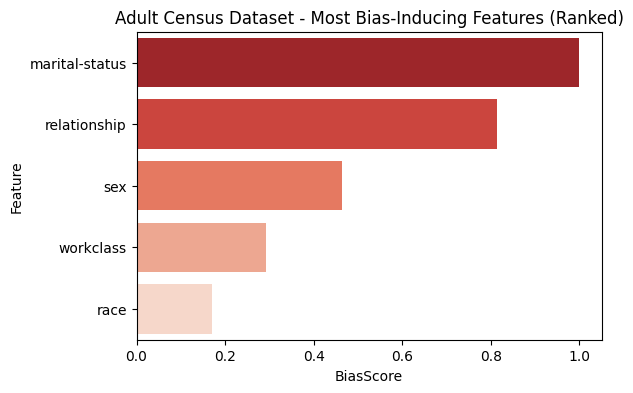

In [203]:
# Ranking bar plot
plt.figure(figsize=(6,4))
sns.barplot(data=results_df, x="BiasScore", y="Feature", palette="Reds_r")
plt.title("Adult Census Dataset - Most Bias-Inducing Features (Ranked)")
plt.show()

##German

In [204]:
df = pd.read_csv("/content/drive/MyDrive/UCL_MSc_AI/UCLFinalProj/FinalProj_Main/datasets/German/Raw/German_orig.csv")
target = "credit_risk"

candidate_protected = ["sex", "age", "marital_status"]

# Identify columns to exclude from encoding (which is just the target column)
cols_to_exclude = [target, "sex", "age", "marital_status"]

df, encoders = encode_categoricals(df, exclude=cols_to_exclude)

X = df.drop(columns=[target])
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=57)

# Train model
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

clf = LogisticRegression(max_iter=1000)
clf.fit(X_train_scaled, y_train)
y_pred = clf.predict(X_test_scaled)

In [205]:
# Fairness Evaluation Across Multiple Features
results = []

for protected in candidate_protected:
    sens = X_test[protected].values

    # Wrap dataset for AIF360
    dataset = BinaryLabelDataset(
        favorable_label=1,
        unfavorable_label=0,
        df=pd.DataFrame(X_test, columns=X_test.columns).assign(label=y_test.values, **{protected: sens}),
        label_names=['label'],
        protected_attribute_names=[protected]
    )

    dataset_pred = dataset.copy()
    dataset_pred.labels = y_pred.reshape(-1,1)

    # Fairness metrics
    metric_data = BinaryLabelDatasetMetric(dataset, privileged_groups=[{protected:1}], unprivileged_groups=[{protected:0}])
    metric_clf = ClassificationMetric(dataset, dataset_pred,
                                      privileged_groups=[{protected:1}],
                                      unprivileged_groups=[{protected:0}])

    results.append({
        "Feature": protected,
        "SPD": metric_clf.statistical_parity_difference(),
        "EOD": metric_clf.equal_opportunity_difference(),
        "AOD": metric_clf.average_odds_difference()
    })

results_df = pd.DataFrame(results)

In [206]:
# Normalize SPD, EOD, AOD by absolute max for comparability
for col in ["SPD","EOD","AOD"]:
    results_df[col+"_norm"] = results_df[col] / results_df[col].abs().max()

# Ranking by average absolute normalized bias
results_df["BiasScore"] = results_df[["SPD_norm","EOD_norm","AOD_norm"]].abs().mean(axis=1)
results_df = results_df.sort_values("BiasScore", ascending=False)

print("Fairness metrics ranked by bias severity:")
print(results_df[["Feature","SPD","EOD","AOD","BiasScore"]])

Fairness metrics ranked by bias severity:
          Feature       SPD       EOD       AOD  BiasScore
1             age -0.287831 -0.128112 -0.225620   1.000000
2  marital_status  0.155205  0.117548  0.174159   0.742894
0             sex -0.110488 -0.075499 -0.099649   0.471616


/tmp/ipython-input-989827426.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_df, x="BiasScore", y="Feature", palette="Reds_r")


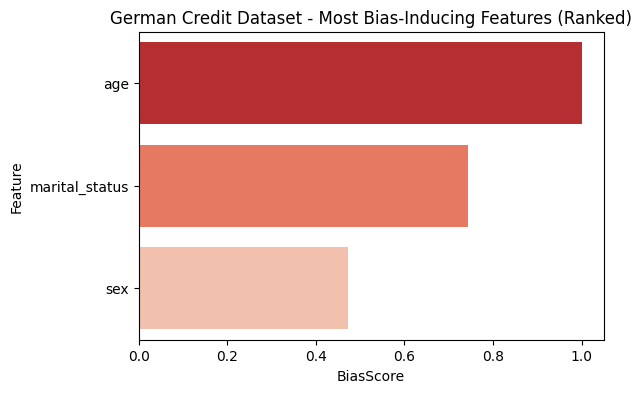

In [207]:
# Ranking bar plot
plt.figure(figsize=(6,4))
sns.barplot(data=results_df, x="BiasScore", y="Feature", palette="Reds_r")
plt.title("German Credit Dataset - Most Bias-Inducing Features (Ranked)")
plt.show()

##Student

In [208]:
df = pd.read_csv("/content/drive/MyDrive/UCL_MSc_AI/UCLFinalProj/FinalProj_Main/datasets/Student/Raw/Student_orig.csv")
target = "dropout"

# Define privileged vs unprivileged groups
df['Marital Status'] = df['Marital Status'].apply(lambda x: 1 if x == 1 else 0)

candidate_protected = ["Gender", "age", "Marital Status", "Debtor", "Tuition fees up to date", "Displaced"]

# Identify columns to exclude from encoding (which is just the target column)
cols_to_exclude = [target, "Gender", "age", "Marital Status", "Debtor", "Tuition fees up to date", "Displaced"]

df, encoders = encode_categoricals(df, exclude=cols_to_exclude)

X = df.drop(columns=[target])
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=57)

# Train model
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

clf = LogisticRegression(max_iter=1000)
clf.fit(X_train_scaled, y_train)
y_pred = clf.predict(X_test_scaled)

In [209]:
# Fairness Evaluation Across Multiple Features
results = []

for protected in candidate_protected:
    sens = X_test[protected].values

    # Wrap dataset for AIF360
    dataset = BinaryLabelDataset(
        favorable_label=1,
        unfavorable_label=0,
        df=pd.DataFrame(X_test, columns=X_test.columns).assign(label=y_test.values, **{protected: sens}),
        label_names=['label'],
        protected_attribute_names=[protected]
    )

    dataset_pred = dataset.copy()
    dataset_pred.labels = y_pred.reshape(-1,1)

    # Fairness metrics
    metric_data = BinaryLabelDatasetMetric(dataset, privileged_groups=[{protected:1}], unprivileged_groups=[{protected:0}])
    metric_clf = ClassificationMetric(dataset, dataset_pred,
                                      privileged_groups=[{protected:1}],
                                      unprivileged_groups=[{protected:0}])

    results.append({
        "Feature": protected,
        "SPD": metric_clf.statistical_parity_difference(),
        "EOD": metric_clf.equal_opportunity_difference(),
        "AOD": metric_clf.average_odds_difference()
    })

results_df = pd.DataFrame(results)

In [210]:
# Normalize SPD, EOD, AOD by absolute max for comparability
for col in ["SPD","EOD","AOD"]:
    results_df[col+"_norm"] = results_df[col] / results_df[col].abs().max()

# Ranking by average absolute normalized bias
results_df["BiasScore"] = results_df[["SPD_norm","EOD_norm","AOD_norm"]].abs().mean(axis=1)
results_df = results_df.sort_values("BiasScore", ascending=False)

print("Fairness metrics ranked by bias severity:")
print(results_df[["Feature","SPD","EOD","AOD","BiasScore"]])

Fairness metrics ranked by bias severity:
                   Feature       SPD       EOD       AOD  BiasScore
4  Tuition fees up to date -0.744863 -0.452109 -0.418912   1.000000
3                   Debtor  0.363057  0.145541  0.133883   0.376309
1                      age -0.347336 -0.035422 -0.155709   0.305452
0                   Gender  0.238060  0.074652  0.072194   0.219019
2           Marital Status -0.172236  0.001983 -0.064817   0.130115
5                Displaced -0.108146 -0.000752 -0.061214   0.097660


/tmp/ipython-input-385515441.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_df, x="BiasScore", y="Feature", palette="Reds_r")


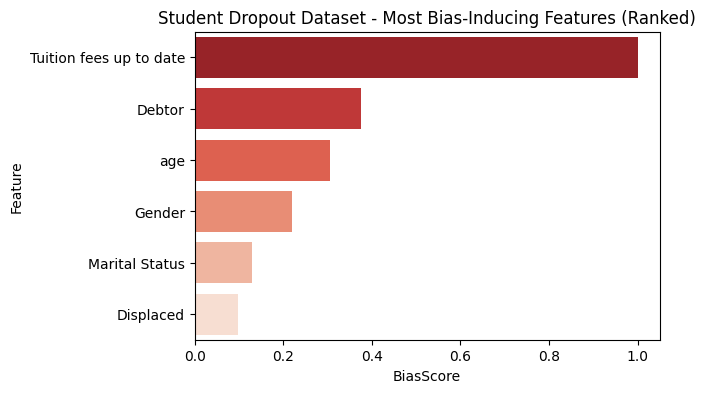

In [211]:
# Ranking bar plot
plt.figure(figsize=(6,4))
sns.barplot(data=results_df, x="BiasScore", y="Feature", palette="Reds_r")
plt.title("Student Dropout Dataset - Most Bias-Inducing Features (Ranked)")
plt.show()

# Normalised Plots for Key Sensitive Features
Levels of bias for each dataset in each domain is normalised and plotted, for all key sensitive feature. The fairness metrics are normalised within each domain for each sensitive feature. Thus, the dataset with the highest bias is given a score of 1 and the rest of the datasets' bias is normalised against its score. THe bias score is the mean of the normalised metric scores.

###Adult

In [219]:
# Define dataset folders
dataset_paths = {    "Adult": "/content/drive/MyDrive/UCL_MSc_AI/UCLFinalProj/FinalProj_Main/datasets/Adult/Raw/",
}

# Define target column per dataset
targets = {
    "Adult": "income",
}

# Protected attributes
protected_attrs = {
    "Adult": ["sex", "race"],
}

In [220]:
final_results_adult = process_datasets(dataset_paths, targets, protected_attrs)

Processing dataset: Adult
  → File: Adult_Census_GenAlgo.csv
  → File: Adult_Census_2015.csv
  → File: Adult_Census_2010.csv
  → File: Adult_Census_2005.csv
  → File: Adult_Census_2000.csv
  → File: Adult_Census_orig.csv
  → File: Adult_Census_bias1.csv
  → File: Adult_Census_bias2.csv
  → File: Adult_Census_bias3.csv
  → File: Adult_Census_bias4.csv
  → File: Adult_Race_bias1.csv
  → File: Adult_Race_bias2.csv
  → File: Adult_Race_bias3.csv
  → File: Adult_Race_bias4.csv
  → File: Adult_Race_GenAlgo.csv
Final Bias Scan Summary:


,Dataset,Feature,SPD,EOD,AOD,SPD_norm,EOD_norm,AOD_norm,BiasScore
0,Adult_Census_GenAlgo.csv,sex,-0.336130,-0.246455,-0.224878,-0.830144,-0.792074,-0.677485,0.766568
1,Adult_Census_GenAlgo.csv,race,-0.307920,-0.264383,-0.249109,-0.682545,-0.854527,-0.766774,0.767949
2,Adult_Census_2015.csv,sex,-0.127523,-0.297086,-0.178275,-0.314945,-0.954795,-0.537085,0.602275
3,Adult_Census_2015.csv,race,-0.032084,-0.073184,-0.043895,-0.071118,-0.236540,-0.135112,0.147590
4,Adult_Census_2010.csv,sex,-0.122827,-0.293503,-0.176068,-0.303348,-0.943282,-0.530438,0.592356


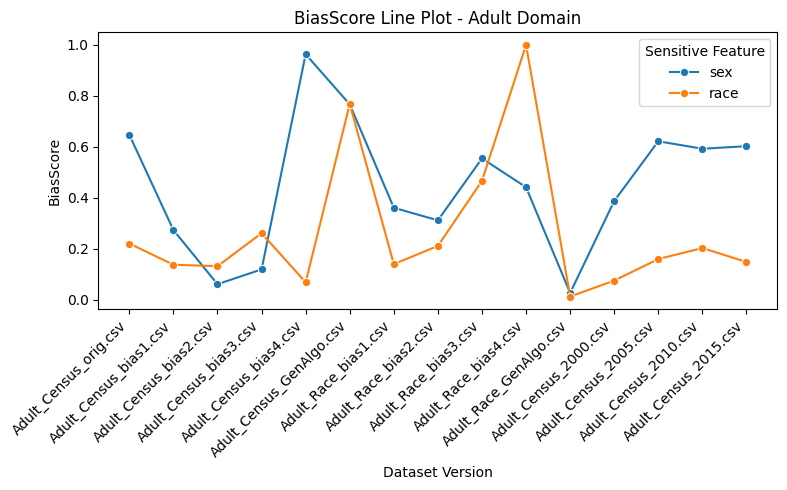

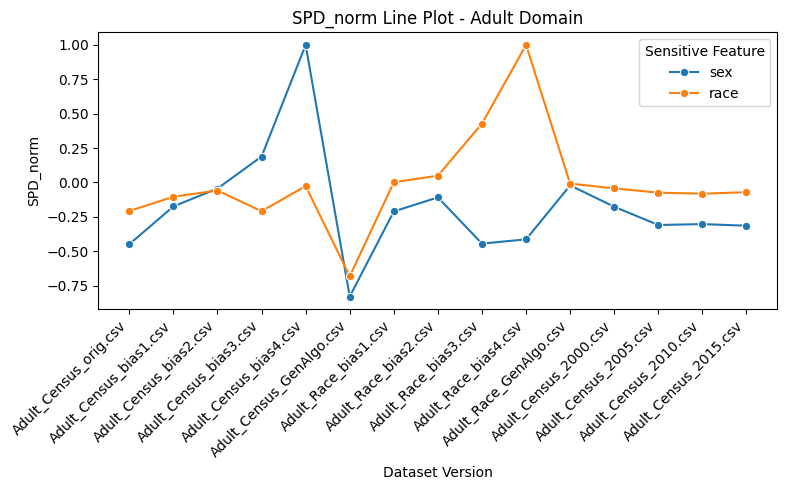

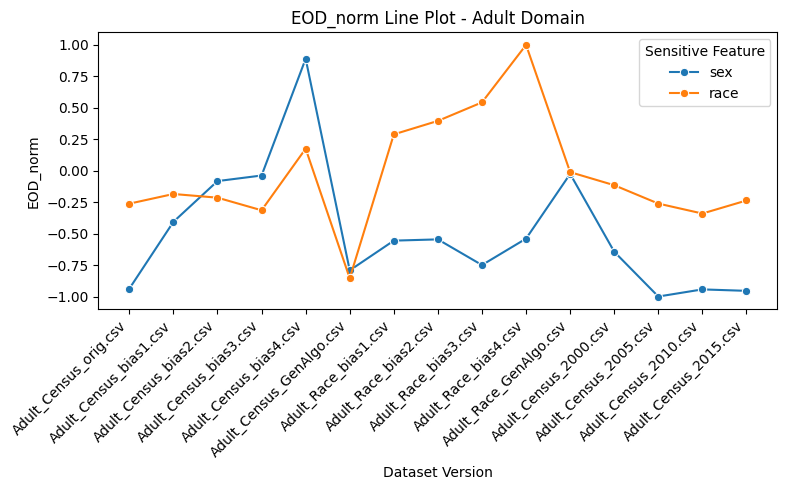

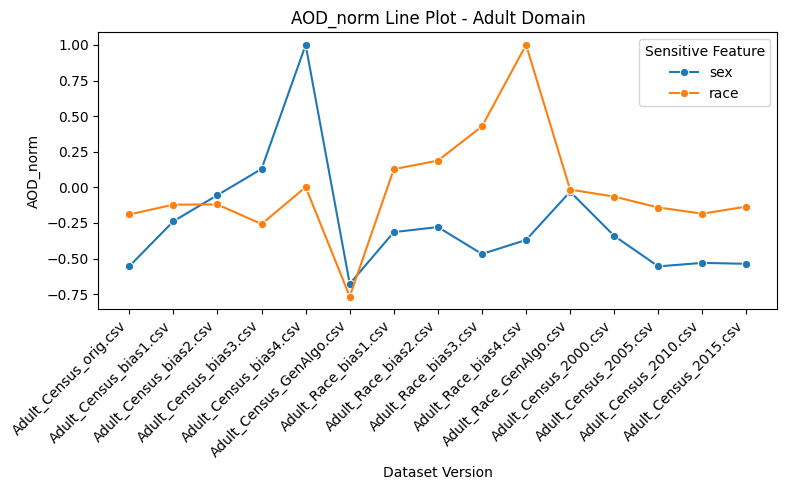

In [221]:
# --- Extract domain from Dataset column ---
final_results_adult["Domain"] = final_results_adult["Dataset"].str.split("_").str[0]

# Define the specific order of datasets per domain
dataset_order = [
    "Adult_Census_orig.csv",
    "Adult_Census_bias1.csv",
    "Adult_Census_bias2.csv",
    "Adult_Census_bias3.csv",
    "Adult_Census_bias4.csv",
    "Adult_Census_GenAlgo.csv",
    "Adult_Race_bias1.csv",
    "Adult_Race_bias2.csv",
    "Adult_Race_bias3.csv",
    "Adult_Race_bias4.csv",
    "Adult_Race_GenAlgo.csv",
    "Adult_Census_2000.csv",
    "Adult_Census_2005.csv",
    "Adult_Census_2010.csv",
    "Adult_Census_2015.csv"
]

metric = ["BiasScore", "SPD_norm","EOD_norm","AOD_norm"]

# --- Loop through each domain ---
for metric_name in metric:
    subset = final_results_adult[final_results_adult["Domain"] == "Adult"].copy()

    # Set Dataset as categorical with the desired order
    subset["Dataset"] = pd.Categorical(subset["Dataset"], categories=dataset_order, ordered=True)

    plt.figure(figsize=(8, 5))

    # One line per feature across dataset versions
    sns.lineplot(
        data=subset,
        x="Dataset",
        y=metric_name,
        hue="Feature",
        marker="o"
    )

    plt.title(f"{metric_name} Line Plot - Adult Domain")
    plt.xlabel("Dataset Version")
    plt.ylabel(metric_name)
    plt.xticks(rotation=45, ha="right")  # rotate labels for readability
    plt.legend(title="Sensitive Feature")
    plt.tight_layout()
    plt.show()

In [222]:
final_results_adult

,Dataset,Feature,SPD,EOD,AOD,SPD_norm,EOD_norm,AOD_norm,BiasScore,Domain
0,Adult_Census_GenAlgo.csv,sex,-0.336130,-0.246455,-0.224878,-0.830144,-0.792074,-0.677485,0.766568,Adult
1,Adult_Census_GenAlgo.csv,race,-0.307920,-0.264383,-0.249109,-0.682545,-0.854527,-0.766774,0.767949,Adult
2,Adult_Census_2015.csv,sex,-0.127523,-0.297086,-0.178275,-0.314945,-0.954795,-0.537085,0.602275,Adult
3,Adult_Census_2015.csv,race,-0.032084,-0.073184,-0.043895,-0.071118,-0.236540,-0.135112,0.147590,Adult
4,Adult_Census_2010.csv,sex,-0.122827,-0.293503,-0.176068,-0.303348,-0.943282,-0.530438,0.592356,Adult
5,Adult_Census_2010.csv,race,-0.037099,-0.105291,-0.060097,-0.082235,-0.340317,-0.184982,0.202512,Adult
6,Adult_Census_2005.csv,sex,-0.125491,-0.311151,-0.184269,-0.309927,-1.000000,-0.555144,0.621690,Adult
7,Adult_Census_2005.csv,race,-0.033721,-0.080793,-0.046028,-0.074747,-0.261135,-0.141678,0.159187,Adult
8,Adult_Census_2000.csv,sex,-0.071683,-0.200332,-0.113218,-0.177038,-0.643841,-0.341091,0.387323,Adult
9,Adult_Census_2000.csv,race,-0.019582,-0.035623,-0.021132,-0.043405,-0.115139,-0.065045,0.074530,Adult


### German

In [227]:
# Define dataset folders
dataset_paths = {
    "German": "/content/drive/MyDrive/UCL_MSc_AI/UCLFinalProj/FinalProj_Main/datasets/German/Raw/"
}

# Define target column per dataset
targets = {
    "German": "credit_risk"
}

# Protected attributes
protected_attrs = {
    "German": ["sex", "age"]
}

In [228]:
final_results_german = process_datasets(dataset_paths, targets, protected_attrs)

Processing dataset: German
  → File: German_orig.csv
  → File: German_bias1.csv
  → File: German_bias2.csv
  → File: German_bias3.csv
  → File: German_bias4.csv
  → File: German_Age_bias1.csv
  → File: German_Age_bias2.csv
  → File: German_Age_bias3.csv
  → File: German_Age_bias4.csv
  → File: German_GenAlgo_age.csv
  → File: German_GenAlgo_sex.csv
Final Bias Scan Summary:


,Dataset,Feature,SPD,EOD,AOD,SPD_norm,EOD_norm,AOD_norm,BiasScore
0,German_orig.csv,sex,-0.110488,-0.075499,-0.099649,-0.235160,-0.202167,-0.239827,0.225718
1,German_orig.csv,age,-0.287831,-0.128112,-0.225620,-0.787925,-0.427273,-0.754538,0.656579
2,German_bias1.csv,sex,0.156793,0.218182,0.060359,0.333715,0.584238,0.145268,0.354407
3,German_bias1.csv,age,-0.175000,-0.049843,-0.202056,-0.479055,-0.166234,-0.675735,0.440341
4,German_bias2.csv,sex,0.469841,0.373447,0.415503,1.000000,1.000000,1.000000,1.000000


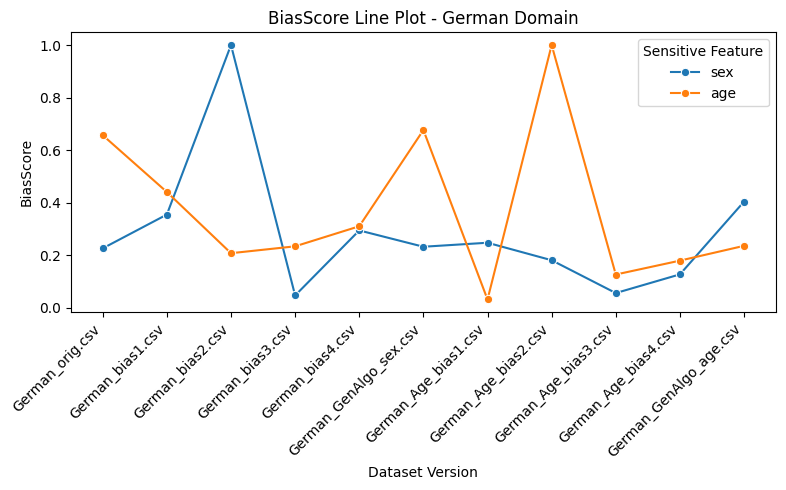

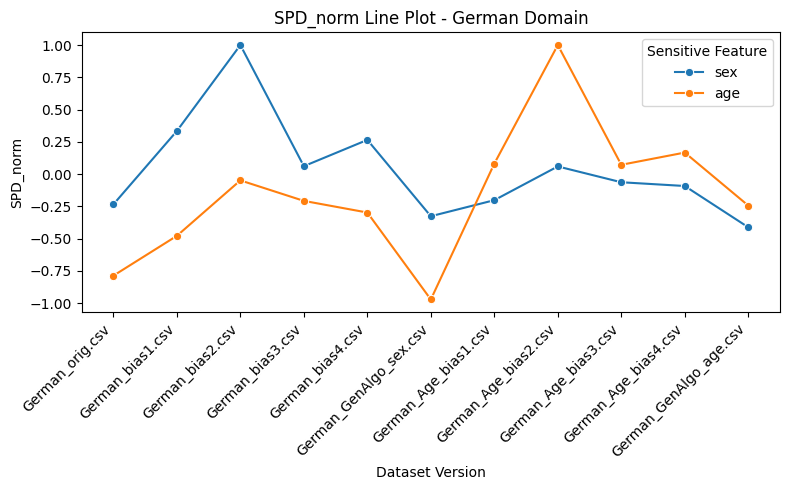

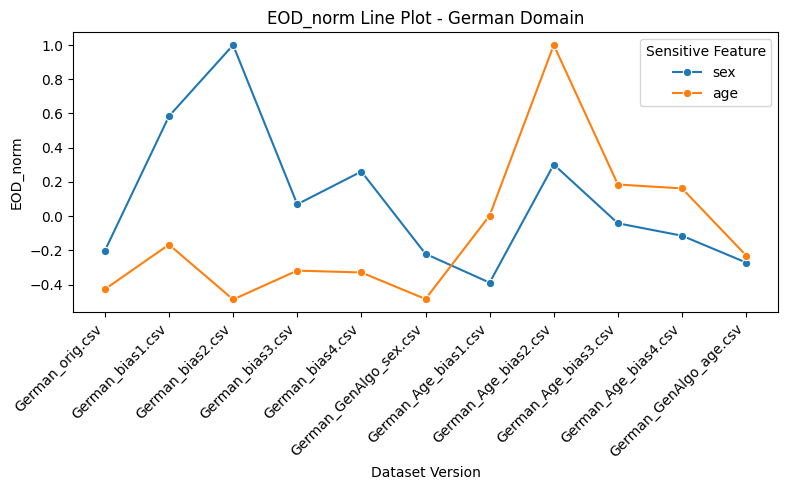

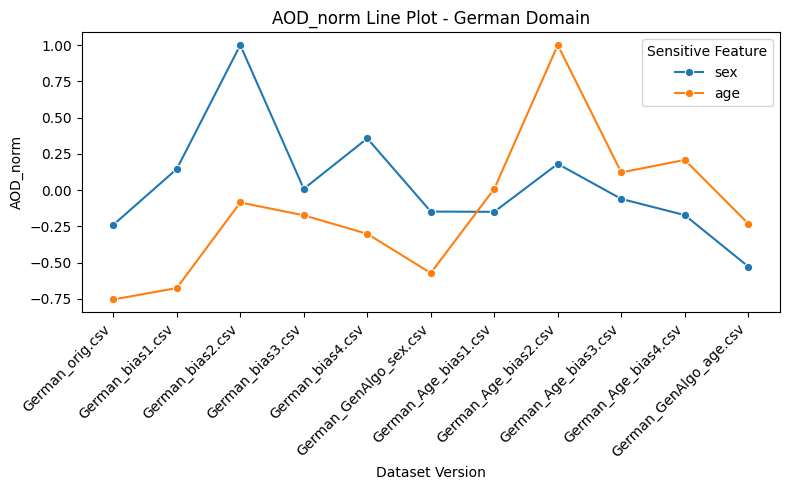

In [229]:
# --- Extract domain from Dataset column ---
final_results_german["Domain"] = final_results_german["Dataset"].str.split("_").str[0]

# Define the specific order of datasets per domain
dataset_order = [
    "German_orig.csv",
    "German_bias1.csv",
    "German_bias2.csv",
    "German_bias3.csv",
    "German_bias4.csv",
    "German_GenAlgo_sex.csv",
    "German_Age_bias1.csv",
    "German_Age_bias2.csv",
    "German_Age_bias3.csv",
    "German_Age_bias4.csv",
    "German_GenAlgo_age.csv"
]

metric = ["BiasScore", "SPD_norm","EOD_norm","AOD_norm"]

# --- Loop through each domain ---
for metric_name in metric:
    subset = final_results_german[final_results_german["Domain"] == "German"]

    # Set Dataset as categorical with the desired order
    subset["Dataset"] = pd.Categorical(subset["Dataset"], categories=dataset_order, ordered=True)

    plt.figure(figsize=(8, 5))

    # One line per feature across dataset versions
    sns.lineplot(
        data=subset,
        x="Dataset",
        y=metric_name,
        hue="Feature",
        marker="o"
    )

    plt.title(f"{metric_name} Line Plot - German Domain")
    plt.xlabel("Dataset Version")
    plt.ylabel(metric_name)
    plt.xticks(rotation=45, ha="right")  # rotate labels for readability
    plt.legend(title="Sensitive Feature")
    plt.tight_layout()
    plt.show()

###Student

In [167]:
# Define dataset folders
dataset_paths = {
    "Student": "/content/drive/MyDrive/UCL_MSc_AI/UCLFinalProj/FinalProj_Main/datasets/Student/Raw/"
}

# Define target column per dataset
targets = {
    "Student": "dropout"
}

# Protected attributes
protected_attrs = {
    "Student": ["Gender", "age"]
}

In [168]:
final_results_student = process_datasets(dataset_paths, targets, protected_attrs)

Processing dataset: Student
  → File: Student_GenAlgo_Sex.csv
  → File: Student_orig.csv
  → File: Student_bias2.csv
  → File: Student_bias3.csv
  → File: Student_bias4.csv
  → File: Student_Age_bias1.csv
  → File: Student_Age_bias2.csv
  → File: Student_Age_bias3.csv
  → File: Student_Age_bias4.csv
  → File: Student_GenAlgo_Age.csv
  → File: Student_bias1.csv
Final Bias Scan Summary:


,Dataset,Feature,SPD,EOD,AOD,SPD_norm,EOD_norm,AOD_norm,BiasScore
0,Student_GenAlgo_Sex.csv,Gender,0.366076,0.382853,0.342579,1.000000,1.000000,1.000000,1.000000
1,Student_GenAlgo_Sex.csv,age,0.253209,0.240238,0.229398,0.722620,1.000000,1.000000,0.907540
2,Student_orig.csv,Gender,0.240179,0.074652,0.074396,0.656090,0.194987,0.217165,0.356081
3,Student_orig.csv,age,-0.350403,-0.035422,-0.158472,-1.000000,-0.147447,-0.690815,0.612754
4,Student_bias2.csv,Gender,-0.259232,-0.245614,-0.188681,-0.708137,-0.641536,-0.550768,0.633480


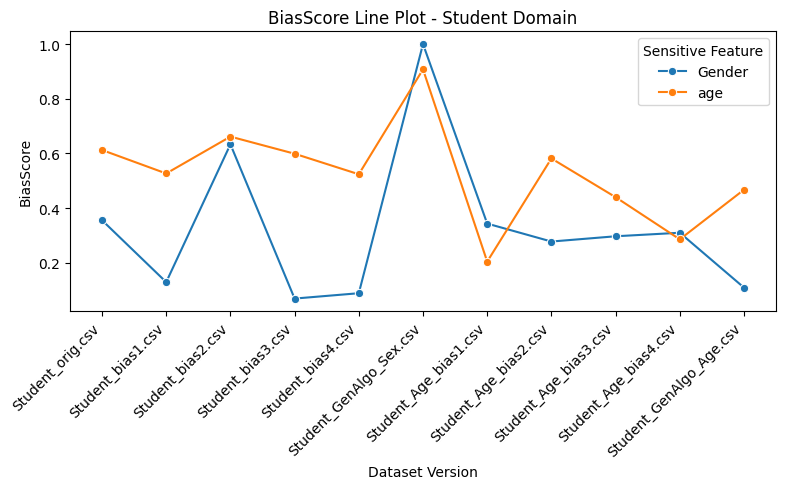

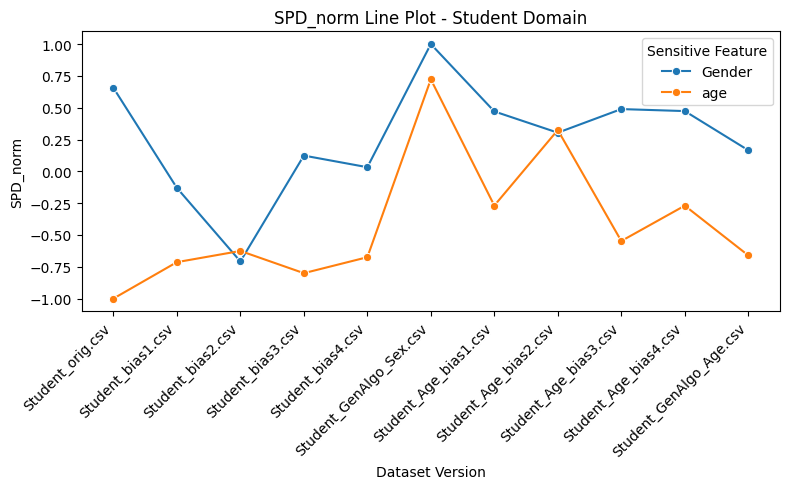

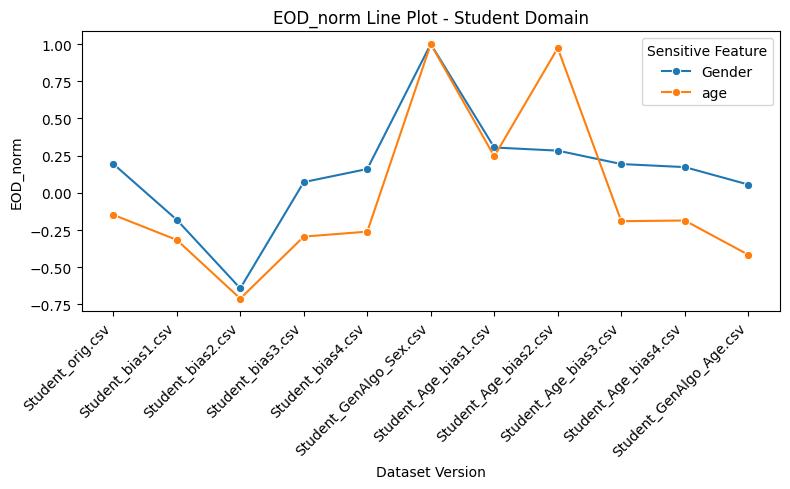

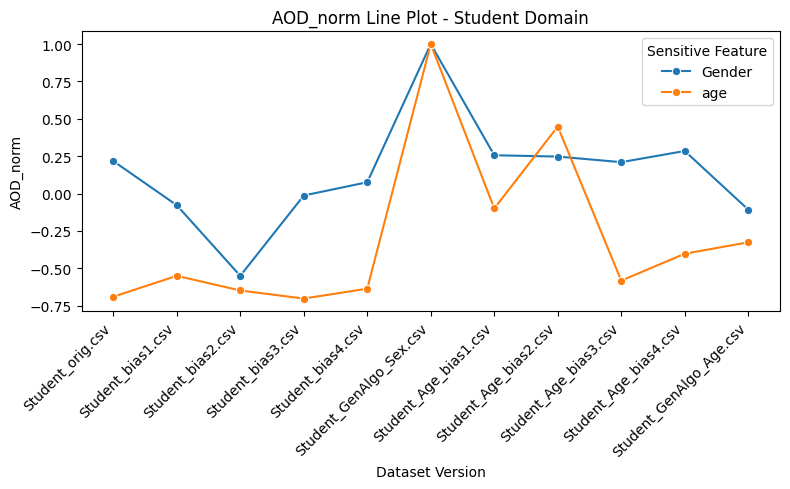

In [172]:
# --- Extract domain from Dataset column ---
final_results_student["Domain"] = final_results_student["Dataset"].str.split("_").str[0]

# Define the specific order of datasets per domain
dataset_order = [
    "Student_orig.csv",
    "Student_bias1.csv",
    "Student_bias2.csv",
    "Student_bias3.csv",
    "Student_bias4.csv",
    "Student_GenAlgo_Sex.csv",
    "Student_Age_bias1.csv",
    "Student_Age_bias2.csv",
    "Student_Age_bias3.csv",
    "Student_Age_bias4.csv",
    "Student_GenAlgo_Age.csv"
]

metric = ["BiasScore", "SPD_norm","EOD_norm","AOD_norm"]

# --- Loop through each domain ---
for metric in metric:
    subset = final_results_student[final_results_student["Domain"] == "Student"]

    # Set Dataset as categorical with the desired order
    subset["Dataset"] = pd.Categorical(subset["Dataset"], categories=dataset_order, ordered=True)

    plt.figure(figsize=(8, 5))

    # One line per feature across dataset versions
    sns.lineplot(
        data=subset,
        x="Dataset",
        y=metric,
        hue="Feature",
        marker="o"
    )

    plt.title(f"{metric} Line Plot - Student Domain")
    plt.xlabel("Dataset Version")
    plt.ylabel(metric)
    plt.xticks(rotation=45, ha="right")  # rotate labels for readability
    plt.legend(title="Sensitive Feature")
    plt.tight_layout()
    plt.show()

In [170]:
final_results_student

,Dataset,Feature,SPD,EOD,AOD,SPD_norm,EOD_norm,AOD_norm,BiasScore,Domain
0,Student_GenAlgo_Sex.csv,Gender,0.366076,0.382853,0.342579,1.000000,1.000000,1.000000,1.000000,Student
1,Student_GenAlgo_Sex.csv,age,0.253209,0.240238,0.229398,0.722620,1.000000,1.000000,0.907540,Student
2,Student_orig.csv,Gender,0.240179,0.074652,0.074396,0.656090,0.194987,0.217165,0.356081,Student
3,Student_orig.csv,age,-0.350403,-0.035422,-0.158472,-1.000000,-0.147447,-0.690815,0.612754,Student
4,Student_bias2.csv,Gender,-0.259232,-0.245614,-0.188681,-0.708137,-0.641536,-0.550768,0.633480,Student
5,Student_bias2.csv,age,-0.219289,-0.170657,-0.148880,-0.625818,-0.710367,-0.649004,0.661730,Student
6,Student_bias3.csv,Gender,0.045264,0.027669,-0.004583,0.123647,0.072271,-0.013377,0.069765,Student
7,Student_bias3.csv,age,-0.280456,-0.070636,-0.161278,-0.800381,-0.294023,-0.703048,0.599151,Student
8,Student_bias4.csv,Gender,0.011830,0.061370,0.025843,0.032316,0.160295,0.075437,0.089350,Student
9,Student_bias4.csv,age,-0.236509,-0.062585,-0.146072,-0.674961,-0.260512,-0.636760,0.524078,Student
